In [3]:
import datadotworld as dw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
%matplotlib inline

In [4]:
# load dataset from data.world service
dataset = dw.load_dataset('dgs-kpis/fmd-maintenance')
df = dataset.dataframes['archibus_maintenance_data']

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/datadotworld/models/dataset.py:194: UserWarning:

Unable to set data frame dtypes automatically using archibus_maintenance_data schema. Data types may need to be adjusted manually. Error: Integer column has NA values in column 50

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/datadotworld/util.py:118: DtypeWarning:

Columns (6,8,30,32,34,38,49,53,56,60,68,74,83,85,86,88,90,91) have mixed types. Specify dtype option on import or set low_memory=False.



## prepare data

In [5]:
df = df[['wo_id','date_completed','prob_type','date_requested']]
df['date_completed'] = pd.to_datetime(df['date_completed'])
df['date_requested'] = pd.to_datetime(df['date_requested'])
df.set_index('date_requested', inplace=True)
df['duration'] = df['date_completed'] - df.index
df['fiscal_year'] = np.where(df.index.month >= 7,df.index.year+1, df.index.year)
df.sort_index(inplace=True)

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is 

## filter to get dataframe with only work orders requested in that fiscal year and in doing this exclude all 'test' work orders.¶


In [6]:
fy_list, fy_dfs = [],[]
for year in df['fiscal_year'].unique():
    fy_dfs.append(df.loc[(df['fiscal_year']==year) & 
                        (df['prob_type']!='TEST(DO NOT USE)')])
    fy_list.append(year)
fy_dfs = dict(zip(fy_list,fy_dfs))

## get and store the total number of work orders that were requested in each fiscal year.¶


In [7]:
work_order_volume = []
for key, value in fy_dfs.items():
    work_order_volume.append(value.wo_id.count())
work_order_volume = dict(zip(fy_list,work_order_volume))
work_order_volume


{2014: 12209, 2015: 14522, 2016: 16679, 2017: 17873, 2018: 16593, 2019: 6186}

## drop work orders that were not closed in each fiscal year¶


In [8]:
cleaned_fy_dfs = []
for key, value in fy_dfs.items():
    cleaned_fy_dfs.append(value[value.date_completed.notnull()])
cleaned_fy_dfs = dict(zip(fy_list,cleaned_fy_dfs))

## add columns for the following:
1. work order volume by problem type
2. average duration by problem type
3. status for whether or not specific work orders 'hit' or 'missed' on time

In [9]:
for key, value in cleaned_fy_dfs.items():
    value['count'] = value.groupby(['prob_type'])['prob_type'].transform('count')
    value['avg_duration'] = (value.groupby(['prob_type'])['duration'].\
                        transform('sum') / value['count'])
    value['on_time'] = np.where(value.duration <= value.avg_duration,'hit','miss')

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is 

## display the the work orders closed on time ( divide the number of work orders closed on time by the total number of work orders received in the fiscal year)

In 2014, 67.2% of work orders were closed on time.
In 2015, 78.3% of work orders were closed on time.
In 2016, 74.8% of work orders were closed on time.
In 2017, 69.8% of work orders were closed on time.
In 2018, 65.7% of work orders were closed on time.
In 2019, 49.9% of work orders were closed on time.


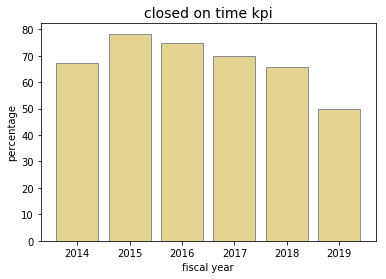

In [10]:
pct_timely_kpi = []
for year in cleaned_fy_dfs.keys():
    (pct_timely_kpi.append(cleaned_fy_dfs[year]['on_time'].
                           value_counts()[0] / work_order_volume[year] * 100))
    print('In {}, {}% of work orders were closed on time.'.format(
            year, round(cleaned_fy_dfs[year]['on_time'].value_counts()[0] / 
                        work_order_volume[year] * 100, 1)))

pct_timely_kpi = dict(zip(fy_list,pct_timely_kpi))

plt.bar(range(len(fy_list)),list(pct_timely_kpi.values()),color='#e2d391',\
        edgecolor='#868e99',align='center')
plt.xticks(range(len(fy_list)),list(pct_timely_kpi.keys()))
plt.title('closed on time kpi',fontsize=14)
plt.xlabel('fiscal year',fontsize=10)
plt.ylabel('percentage',fontsize=10);   

# show results arrived in error from not removing the open work orders.
NOTE: the kpi will be different, potentially higher if the denominator used is the total number of all closed work orders instead of the total number of work orders requested. This measure calls for using the total number of work orders requested as the denominator for work order volume</font>

In [11]:
problematic_non_drop_values_methodology = []
for year in fy_list:
    print('In {}, {} pct of work orders were closed on time.'.\
         format(year,round(cleaned_fy_dfs[year].on_time.value_counts()[0]/ \
         cleaned_fy_dfs[year].wo_id.count()*100,2)))
    problematic_non_drop_values_methodology.append(cleaned_fy_dfs[year].on_time.value_counts()[0]/ \
         cleaned_fy_dfs[year].wo_id.count()*100)
problematic_non_drop_values_methodology = dict(zip(fy_list,problematic_non_drop_values_methodology))

In 2014, 78.47 pct of work orders were closed on time.
In 2015, 79.18 pct of work orders were closed on time.
In 2016, 76.34 pct of work orders were closed on time.
In 2017, 71.89 pct of work orders were closed on time.
In 2018, 71.29 pct of work orders were closed on time.
In 2019, 69.57 pct of work orders were closed on time.


# <font color=blue>pm to cm kpi</font>

In [12]:
# set hvac filters
cm_prob_types = ['BOILER','CHILLERS','COOLING TOWERS',\
                 'HVAC','HVAC INFRASTRUCTURE','HVAC|REPAIR']
pm_prob_types = ['PREVENTIVE MAINT','HVAC|PM']
hvac_prob_types = cm_prob_types+pm_prob_types

## add column for count of each problem type for each year to later see volumes in all pm or all cm or in the work order categories that constitute these groupings

In [13]:
for year in fy_dfs:
    fy_dfs[year]['count'] = fy_dfs[year].groupby(['prob_type'])['prob_type'].transform('count')

/Users/babilalima/Documents/Work_Coding_Projects/data-validation/Data-Validation/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [14]:
pm_cm_kpi = []
for key,value in fy_dfs.items():
    pm_cm_kpi.append(fy_dfs[key][fy_dfs[key].prob_type.isin(pm_prob_types)].\
          prob_type.value_counts().sum() / \
          fy_dfs[key][fy_dfs[key].prob_type.isin(cm_prob_types)].\
                     prob_type.value_counts().sum()*100)

pm_cm_kpi = dict(zip(fy_list,pm_cm_kpi))
pm_cm_kpi

{2014: 0.0,
 2015: 4.768856447688565,
 2016: 46.93877551020408,
 2017: 57.874015748031496,
 2018: 71.65932452276064,
 2019: 75.37777777777778}

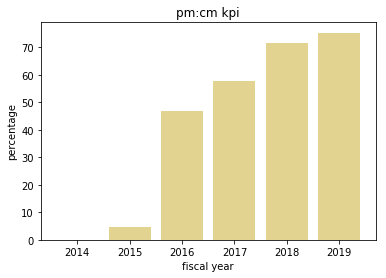

In [16]:
plt.bar(range(len(pm_cm_kpi)),list(pm_cm_kpi.values()),color='#e2d391')
plt.xticks(range(len(pm_cm_kpi)),list(pm_cm_kpi.keys()))
plt.title('pm:cm kpi')
plt.xlabel('fiscal year',fontsize=10)
plt.ylabel('percentage', fontsize=10);